# Load Data

In [1]:
import pandas as pd
import numpy as np
# helpful character encoding module
import chardet
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
from fuzzywuzzy.fuzz import partial_ratio

#determine what kind of encoding csc file uses 
with open("Documents/Data science/cars_and_bids/car_auction_data.csv", 'rb') as rawdata:
    result = chardet.detect(rawdata.read(10000))
print(result)

#read in data 
car_data = pd.read_csv('C:Documents/Data science/cars_and_bids/car_auction_data.csv', encoding = 'ISO-8859-1', )

#set seed for reproduceability
np.random.seed(0)                    

C:\Users\Justyn\anaconda3\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


{'encoding': 'ISO-8859-1', 'confidence': 0.73, 'language': ''}


In [2]:
#raw data
car_data

,Year,Make,Model,Seller,Location,VIN,Mileage,BodyStyle,Engine,Drivetrain,Transmission,ExteriorColor,InteriorColor,TitleStatus,SellerType,Price,Reserve,Horsepower,Torque
0,1990,Land Rover,Defender,alexo,"Los Angeles, CA 90004",SALLDVAB8FA439151,600,SUV/Crossover,6.9L V8,4WD/AWD,Automatic (4-Speed),Eastnor Green,Gray,Clean (TX),Private Party,"$31,500",Has reserve,87,150
1,1984,Toyota,Land Cruiser,ATL_JDM,"Cumming, GA 30041",FJ61000747,1,SUV/Crossover,4.2L I6,4WD/AWD,Manual (4-Speed),Red,Black,Registered in GA,Dealer,"$7,777",Has reserve,99,188
2,1990,Peugeot,205 GTi,AlfaDog2000,"Alpine, NJ 07627",VF320CD6223885978,"32,000",Hatchback,1.9L I4,Front-wheel drive,Manual (5-speed),Alpine White,Quattro,Clean (MT),Private Party,"$17,100",Has reserve,130,118
3,1995,Toyota,T100,Dmiguel,"Los Gatos, CA 95030",JT4VD12FXS0014606,"64,500",Truck,3.4L V6,Rear-wheel drive,Automatic (4-Speed),Red,Beige,Clean (CA),Private Party,"$8,000",Has reserve,150,[]
4,2003,Mazda,Mazdaspeed Protege,young_timer,"Portland, OR 97212",JM1BJ227X30644914,"63,100",Sedan,2.0L Turbocharged Inline-4,Front-wheel drive,Manual (5-Speed),Titanium Gray,Black,Clean (OR),Private Party,"$6,700",Has reserve,170,[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1178,2013,Mercedes-Benz,S65 AMG,1ofX,"Haymarket, VA 20169",WDDNG7KB3DA501365,"66,700",Sedan,6.0L Turbocharged V12,Rear-wheel drive,Automatic (5-Speed),Mocha Black,Armagnac Brown,Clean (AZ),Dealer,"$38,000",Has reserve,621,738
1179,1983,Mercedes-Benz,240D,ejbrooks,"Batavia, NY 14020",WDBAB23A9DB413557,"275,200",Sedan,2.4L Diesel I4,Rear-wheel drive,Manual (4-speed),White,Blue,Clean (NY),Private Party,"$3,250",No reserve,71,101
1180,1994,Land Rover,Defender,RelicImports,"Charleston, SC 29414",SALLDHMV8LA930542,"47,316",Truck,3.5L V8,4WD/AWD,Manual (5-speed),Red,Black,Clean (SC),Dealer,"$32,000",Has reserve,85,150
1181,2020,Jeep,Gladiator,JoeLeone,"Elma, NY 14059",1C6JJTBG8LL130583,"13,000",Truck,6.4L V8,4WD/AWD,Automatic (8-speed),Billet Silver Metallic,Black and Red,Clean (NY),Private Party,"$57,500",Has reserve,NaN,NaN


# Clean Data

In [3]:
#check how much data is missing from each column
total = car_data.isnull().sum().sort_values(ascending=False)
percent = (car_data.isnull().sum()/car_data.isnull().count()).sort_values(ascending = False)
missing_data = pd.concat([total, percent], axis = 1, keys = ['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
Torque,2,0.001691
Horsepower,2,0.001691
Mileage,1,0.000845
Engine,0,0.000000
Make,0,0.000000
Model,0,0.000000
Seller,0,0.000000
Location,0,0.000000
VIN,0,0.000000
BodyStyle,0,0.000000


In [4]:
#Drop rows with missing data 
car_data = car_data.dropna();
#checking that there's no missing data missing...
car_data.isnull().sum().max()

0

In [5]:
#Remove cancelled car auctions from data (cancelled tag in sale price)
car_data = car_data[car_data.Price != 'Cancelled']
car_data.Price

0       $31,500
1        $7,777
2       $17,100
3        $8,000
4        $6,700
         ...   
1176    $43,750
1177    $30,750
1178    $38,000
1179     $3,250
1180    $32,000
Name: Price, Length: 1171, dtype: object

In [6]:
#Check how many unique values per column. This is to find Non numerical columns with 
#many values becuse these will probably be dropped due to not being able to encode
for col in car_data:
    print(col, car_data[col].nunique())

Year 40
Make 63
Model 422
Seller 988
Location 934
VIN 1158
Mileage 891
BodyStyle 8
Engine 253
Drivetrain 3
Transmission 36
ExteriorColor 609
InteriorColor 255
TitleStatus 91
SellerType 17
Price 591
Reserve 2
Horsepower 373
Torque 369


In [7]:
#Drop seller, model and VIN. Seller doesn't add any price info and wouldn't help predict
#Engine, exteriorcolor, and interiorcolor categories could maybe grouped into more general categories 
#title status can also be simplified as it includes title state
car_data = car_data.drop(['Model', "VIN", "Seller", "TitleStatus"], axis=1)

In [8]:
#remove $ and commas from price data
car_data['Price'] = car_data['Price'].str.replace(',', '')
car_data['Price'] = car_data['Price'].str.replace('$', '')
car_data['Price'] = car_data['Price'].astype(int)

In [9]:
#Horsepower has more then one value. This is because more then one value of horsepower was discussed in the description
#Use only first value given in Horsepower column
car_horsepower = car_data['Horsepower'].str.split(pat=',', expand=True)
#same done for torque
car_torque = car_data['Torque'].str.split(pat=',', expand=True)

In [10]:
#remove extra characters from torque and horsepower
from math import nan

#replace any non numerical digit and replace with empty string 
for column in range(6):
    car_horsepower[column].replace('[^\d]', "",regex=True, inplace = True)
for column in range(3):
    car_torque[column].replace('[^\d]', "",regex=True, inplace = True)

#convert empty strings to NaN
for column in range(6):
    car_horsepower[column].replace('', nan, regex=True, inplace = True)
for column in range(3):
    car_torque[column].replace('', nan, regex=True, inplace = True)
    
car_horsepower = car_horsepower.astype(float).max(axis = 1)
car_torque = car_torque.astype(float).max(axis = 1)


In [11]:
#update dataframe with new horsepower and torque columns
car_data['Horsepower'] = car_horsepower
car_data['Torque'] = car_torque

#recheck how much data is missing from each column
total = car_data.isnull().sum().sort_values(ascending=False)
percent = (car_data.isnull().sum()/car_data.isnull().count()).sort_values(ascending = False)
missing_data = pd.concat([total, percent], axis = 1, keys = ['Total', 'Percent'])

car_data.dropna(axis=0, inplace = True)

In [12]:
#remove $ and commas from price
car_data['Mileage'] = car_data['Mileage'].str.replace('[^\d]', "")
car_data['Mileage'] = car_data['Mileage'].astype(int)

In [13]:
#descriptive stats summary of variable we want to predict
car_data["Horsepower"].describe()

count    1141.000000
mean      298.218230
std       140.766756
min        41.000000
25%       200.000000
50%       282.000000
75%       375.000000
max      2186.000000
Name: Horsepower, dtype: float64

In [14]:
#check distrubution of the data 
print('Skewness: %f' % car_data['Price'].skew())
print('Kurtosis: %f' % car_data['Price'].kurtosis())

Skewness: 3.850716
Kurtosis: 23.192058


C:\Users\Justyn\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


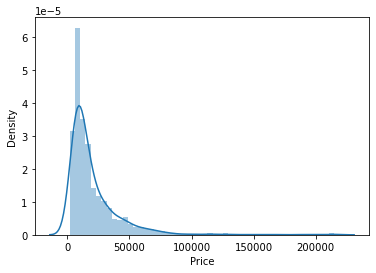

In [15]:
#histogram
sns.distplot(car_data['Price']);

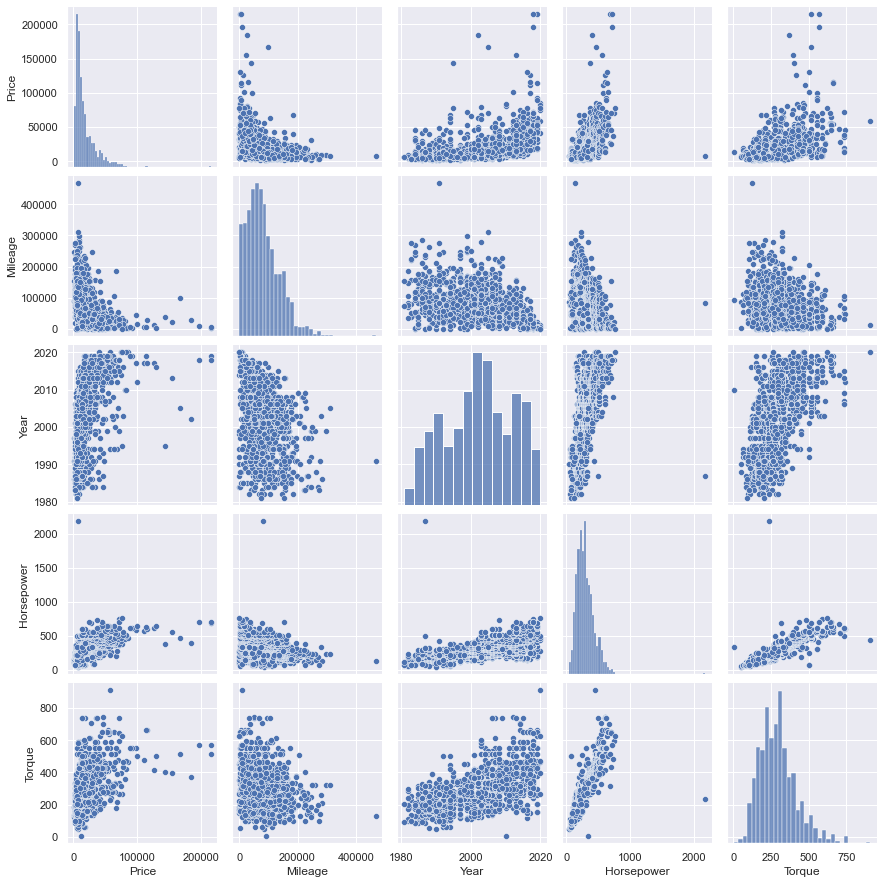

In [16]:
#scatterplots 
sns.set()
cols = ['Price', 'Mileage', 'Year', 'Horsepower', 'Torque']
sns.pairplot(car_data[cols], height = 2.5)
plt.show();

In [17]:
#Horsepower looks to have a large outlier. It is probably occured when cleaning the data becuase 
#no car should have 2000 hp 
car_data['Price'].describe()

count      1141.000000
mean      20084.931639
std       21698.418436
min        1800.000000
25%        7877.000000
50%       12750.000000
75%       24569.000000
max      215002.000000
Name: Price, dtype: float64

In [18]:
#after checking the original data this Porche had 218.6 hp. Looks like it was the only car 
#with a decimal value for hp
car_data[car_data.Horsepower == 2186] = car_data[car_data.Horsepower == 2186].replace(2186, 219)

In [19]:
car_data[car_data.Horsepower == 219]

,Year,Make,Location,Mileage,BodyStyle,Engine,Drivetrain,Transmission,ExteriorColor,InteriorColor,SellerType,Price,Reserve,Horsepower,Torque
9,1987,Porsche,"Leeds, AL 35094",81900,Coupe,3.0L I4,Rear-wheel drive,Manual (5-speed),Guards Red,Black,Private Party,7200,No reserve,219.0,236.0


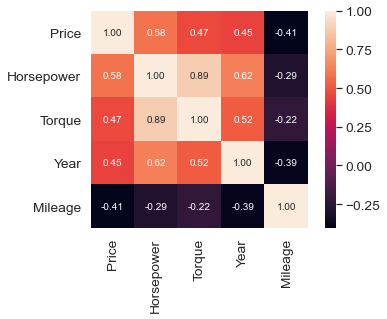

In [20]:
#Price correlation matrix
corrmat = car_data.corr()
k = 5 #number of variables for heatmap
cols = corrmat.nlargest(k, 'Price')['Price'].index
cm = np.corrcoef(car_data[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar = True, annot = True, square=True, fmt='.2f', annot_kws={'size':10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

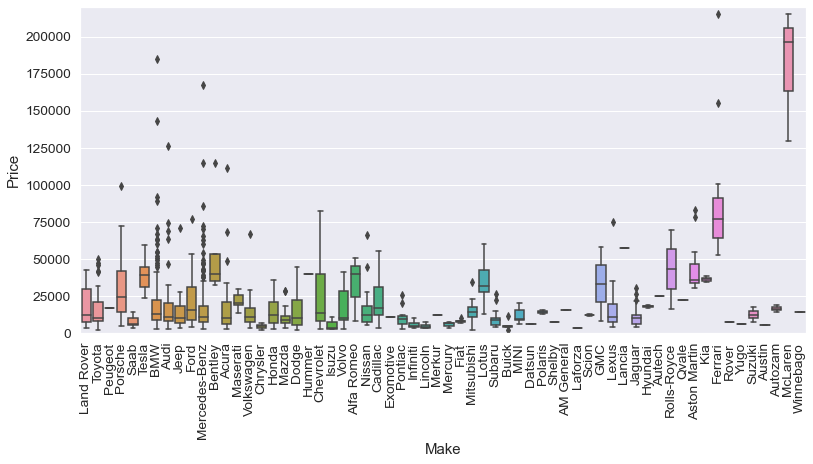

In [21]:
#Relationship with catagorical features
#box plot of Price Vs Car Make

var = 'Make'
data = pd.concat([car_data['Price'], car_data[var]], axis = 1)
f, ax = plt.subplots(figsize=(13, 6))
fig = sns.boxplot(x=var, y='Price', data = data)
fig.axis(ymin = 0, ymax = 220000);
fig.set_xticklabels(fig.get_xticklabels(), rotation=90);

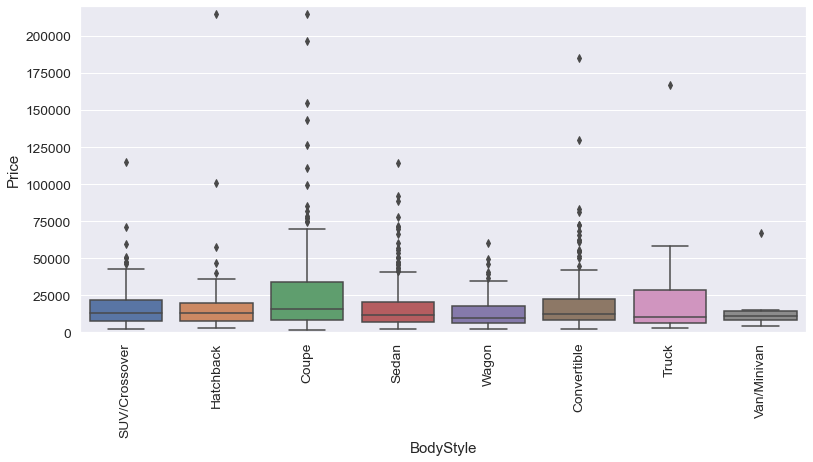

In [22]:
#Boxplot of Price vs Bodystyle 
var = 'BodyStyle'
data = pd.concat([car_data['Price'], car_data[var]], axis = 1)
f, ax = plt.subplots(figsize=(13, 6))
fig = sns.boxplot(x=var, y='Price', data = data)
fig.axis(ymin = 0, ymax = 220000);
fig.set_xticklabels(fig.get_xticklabels(), rotation=90);

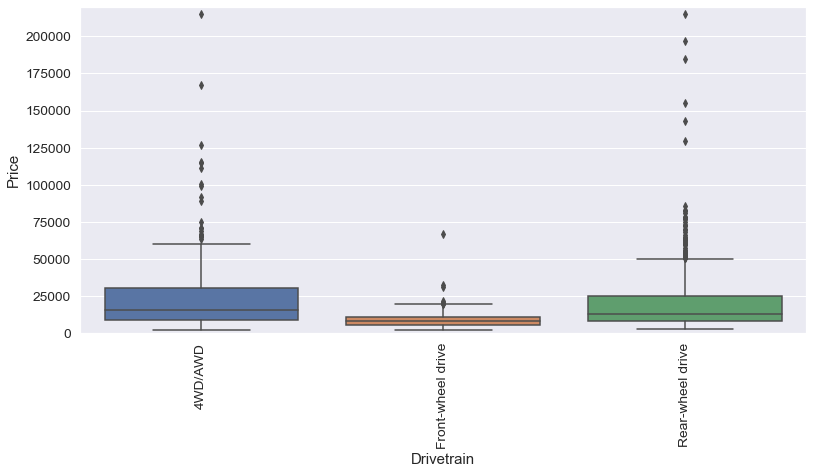

In [23]:
var = 'Drivetrain'
data = pd.concat([car_data['Price'], car_data[var]], axis = 1)
f, ax = plt.subplots(figsize=(13, 6))
fig = sns.boxplot(x=var, y='Price', data = data)
fig.axis(ymin = 0, ymax = 220000);
fig.set_xticklabels(fig.get_xticklabels(), rotation=90);

In [24]:
#convert transmission to all lower case and investigate how many different types of transmissions are in the data set
car_data['Transmission'] = car_data['Transmission'].str.lower()
car_data['Transmission'].value_counts()

manual (6-speed)                   286
manual (5-speed)                   212
automatic (4-speed)                195
automatic (5-speed)                142
automatic (6-speed)                112
automatic (7-speed)                 84
automatic (8-speed)                 43
automatic (3-speed)                 18
manual (4-speed)                    13
manual (7-speed)                     8
automatic                            7
automatic (9-speed)                  6
automatic (10-speed)                 2
automatic (1-speed)                  2
manual (6-speed manual)              2
manual (5-speed manual)              2
automatic (7-speed pdk)              1
automatic (7-speed mct)              1
automatic (7-speed dual-clutch)      1
automatic (6-speed dct)              1
automatic (6-speed f1)               1
automatic (cvt)                      1
automatic (6-speed dual clutch)      1
Name: Transmission, dtype: int64

In [25]:
#looks like there are some varied decriptions used in some of the car listings. These can be corrected to reduced number of catagories
car_data[car_data.Transmission == 'automatic (1-speed)'] = car_data[car_data.Transmission == 'automatic (1-speed)'] .replace('automatic (1-speed)', 'automatic')
car_data[car_data.Transmission == 'manual (5-speed manual)'] = car_data[car_data.Transmission == 'manual (5-speed manual)'].replace('manual (5-speed manual)', 'manual (5-speed)')
car_data[car_data.Transmission == 'manual (6-speed manual)'] = car_data[car_data.Transmission == 'manual (6-speed manual)'].replace('manual (6-speed manual)', 'manual (6-speed)')
car_data[car_data.Transmission == 'automatic (7-speed pdk)'] = car_data[car_data.Transmission == 'automatic (7-speed pdk)'].replace('automatic (7-speed pdk)', 'automatic (7-speed)')
car_data[car_data.Transmission == 'automatic (6-speed f1)'] = car_data[car_data.Transmission == 'automatic (6-speed f1)'].replace('automatic (6-speed f1)', 'automatic (6-speed)')
car_data[car_data.Transmission == 'automatic (7-speed mct)'] = car_data[car_data.Transmission == 'automatic (7-speed mct)'].replace('automatic (7-speed mct)', 'automatic (7-speed)')
car_data[car_data.Transmission == 'automatic (7-speed dual-clutch)'] = car_data[car_data.Transmission == 'automatic (7-speed dual-clutch)'].replace('automatic (7-speed dual-clutch)', 'automatic (7-speed)')
car_data[car_data.Transmission == 'automatic (6-speed dual clutch)'] = car_data[car_data.Transmission == 'automatic (6-speed dual clutch)'].replace('automatic (6-speed dual clutch)', 'automatic (6-speed)')
car_data[car_data.Transmission == 'automatic (6-speed dct)'] = car_data[car_data.Transmission == 'automatic (6-speed dct)'].replace('automatic (6-speed dct)', 'automatic (6-speed)')


car_data['Transmission'].value_counts()

manual (6-speed)        288
manual (5-speed)        214
automatic (4-speed)     195
automatic (5-speed)     142
automatic (6-speed)     115
automatic (7-speed)      87
automatic (8-speed)      43
automatic (3-speed)      18
manual (4-speed)         13
automatic                 9
manual (7-speed)          8
automatic (9-speed)       6
automatic (10-speed)      2
automatic (cvt)           1
Name: Transmission, dtype: int64

In [26]:
car_data['ExteriorColor'].str.lower().value_counts().head(20)

black                        100
white                         38
silver                        30
brilliant silver metallic     20
alpine white                  20
titanium silver metallic      19
jet black                     16
black sapphire metallic       15
red                           14
titanium silver               11
guards red                    10
arctic white                  10
gray                           9
polar white                    7
british racing green           7
brilliant black                6
silverstone metallic           6
pearl white                    6
classic red                    5
blue                           5
Name: ExteriorColor, dtype: int64

In [27]:
#looks like there are a few types of sellertype
car_data['SellerType'].str.lower().value_counts().tail(60)

private party                                          898
dealer                                                 216
private party (lien on title)                           13
dealer ($100 dealership fee)                             2
dealer (gr auto gallery)                                 1
dealer ($150 dealership fee)                             1
dealer ($38 dealership fee)                              1
dealer (international motorcars of pittsburgh ltd.)      1
dealer (arizona residents pay 8.6% sales tax)            1
dealer (hancock automotive)                              1
dealer (euroasian auto inc.)                             1
dealer (sales tax & title fees)                          1
dealer (kansas residents pay sales tax)                  1
dealer (fl residents pay sales tax)                      1
dealer ($311 dealer fee)                                 1
private party (clean (az))                               1
Name: SellerType, dtype: int64

In [28]:
#sort Sellertype into either 'private party' or 'dealer'
co_list = ['private party','dealer']

#fuzzywuzzy used to decide if category is more similar to private party or dealer
car_data['SellerType'] = car_data.SellerType.apply(lambda mistyped_co: max(co_list, key=lambda co: partial_ratio(mistyped_co, co)))


In [29]:
#too many unique colors with names that don't 

#Swap exterior color with closest related color in name
#color_list = ['black','white', 'silver', 'grey', 'green', 'red', 'orange', 'blue', 'yellow', 'brown', 'gold']

#car_data['ExteriorColor'] = car_data.ExteriorColor.apply(lambda mistyped_co: max(color_list, key=lambda co: partial_ratio(mistyped_co, co)))

In [30]:
#make a new dataframe without location, engine, Exteriorcolor, interiorcolor
#these are likely useful features but are more difficult to include and would require some tuning. 
#best to have a baseline without including them first

base_data = car_data.drop(['Location', 'Engine', 'InteriorColor', 'ExteriorColor'], axis=1).copy()


In [31]:
base_data.columns

Index(['Year', 'Make', 'Mileage', 'BodyStyle', 'Drivetrain', 'Transmission',
       'SellerType', 'Price', 'Reserve', 'Horsepower', 'Torque'],
      dtype='object')

In [32]:
# Seperate price from data frame 

dataY = base_data.Price
features = ['Year', 'Make', 'Mileage', 'BodyStyle', 'Drivetrain',
       'SellerType', 'Reserve', 'Horsepower', 'Torque', 'Transmission']
dataX = base_data[features].copy()


In [33]:
# Split into train and test sets

from sklearn.model_selection import train_test_split
#split up data into test and train subsets
train_ratio = 0.90
test_ratio = 0.10

x_train, x_test, y_train, y_test = train_test_split(dataX, dataY, test_size=1 - train_ratio, random_state = 0)

In [34]:
# Testing out target encoding 
from category_encoders import TargetEncoder

# Get list of categorical features
s = (dataX.dtypes == 'object')
object_cols = list(s[s].index)

# Create the encoder
target_enc = TargetEncoder(cols=object_cols)
target_enc.fit(x_train[object_cols], y_train)

# Transform the features, rename the columns with _target suffix, and join to dataframe
te_train = x_train.join(target_enc.transform(x_train[object_cols]).add_suffix('_target'))
te_train = te_train.drop(object_cols, axis = 1)
te_test = x_test.join(target_enc.transform(x_test[object_cols]).add_suffix('_target'))
te_test = te_test.drop(object_cols, axis = 1)

C:\Users\Justyn\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [35]:
# function to return one hot encoded categorical features, and the trained encoder

from sklearn.preprocessing import OneHotEncoder
def OHE(X):

    # Create list of categorical variables
    s = (dataX.dtypes == 'object')
    object_cols = list(s[s].index)
    
    # Create One hot encoder
    OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
    # Fit OHE to data
    OH_fit = OH_encoder.fit(X[object_cols])
    # Apply OHE
    OH_cols = pd.DataFrame(OH_encoder.transform(X[object_cols])).copy()
    # Add descriptive column titles to catagorical feature ex. Make_Ferrari
    OH_cols.columns = OH_encoder.get_feature_names(object_cols).copy()

    # One-hot encoding removed index; put it back
    OH_cols.index = X.index

    # Remove categorical columns (will replace with one-hot encoding)
    num_x = X.drop(object_cols, axis=1)

    # Add one-hot encoded columns to numerical features
    OH_X = pd.concat([num_x, OH_cols], axis=1)
    
    #return OH encoded data and trained OH encoder 
    
    return OH_X, OH_encoder

# This function ecodes data given the data you want to encode and a trained encoder
# This can be used on data after the function above so the same trained encoder is used
def OHE_trained(X, OH_encoder):

    s = (dataX.dtypes == 'object')
    object_cols = list(s[s].index)
    
    # Apply one-hot encoder to each column with categorical data
    OH_cols = pd.DataFrame(OH_encoder.transform(X[object_cols])).copy()
    # Add descriptive column titles to catagorical feature ex. Make_Ferrari
    OH_cols.columns = OH_encoder.get_feature_names(object_cols).copy()

    # One-hot encoding removed index; put it back
    OH_cols.index = X.index

    # Remove categorical columns (will replace with one-hot encoding)
    num_x = X.drop(object_cols, axis=1)

    # Add one-hot encoded columns to numerical features
    OH_X = pd.concat([num_x, OH_cols], axis=1)
    
    #return OH encoded data
    return OH_X

In [36]:
# Encode data 
OH_X_train, OH_encode = OHE(x_train)
OH_X_test= OHE_trained(x_test, OH_encode)

In [37]:
OH_X_train

,Year,Mileage,Horsepower,Torque,Make_AM General,Make_Acura,Make_Alfa Romeo,Make_Aston Martin,Make_Audi,Make_Austin,...,Transmission_automatic (5-speed),Transmission_automatic (6-speed),Transmission_automatic (7-speed),Transmission_automatic (8-speed),Transmission_automatic (9-speed),Transmission_automatic (cvt),Transmission_manual (4-speed),Transmission_manual (5-speed),Transmission_manual (6-speed),Transmission_manual (7-speed)
468,2001,81800,247.0,161.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
167,1988,65100,168.0,164.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
923,2010,102200,411.0,434.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
736,2014,7400,332.0,270.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
803,2001,67000,350.0,360.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1060,2018,4000,526.0,429.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
782,2016,22600,345.0,369.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
856,2011,97700,382.0,391.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
576,2000,75500,286.0,324.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [275]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import make_scorer

# Create scorer where MAE is negative. This makes it so a higher score is better which is good for randomizedSearchCV which 
# returns the parameters with the highest score
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

# Create scorer where MAE is Positive. This makes it so a lower score is better which can represent error 
# This is more intuitive when plotting learning curves 
pos_mae_scorer = make_scorer(mean_absolute_error, greater_is_better=True)

In [222]:
# Create and test a random forest regressor 

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

# Create random forrest model
RFR_model = RandomForestRegressor(bootstrap = False, max_depth= 91,max_features = 'sqrt', min_samples_leaf= 1,
                                  min_samples_split= 2, n_estimators= 2237,  random_state = 0)
# Fit data
RFR_model.fit(OH_X_train, y_train)

# check model performance using cross validation and MAE
RFR_scores = cross_val_score(RFR_model, OH_X_train, y_train, cv=5, scoring= mae_scorer)
print(RFR_scores)
RFR_mean = np.mean(RFR_scores)
print(RFR_mean)


RFR_predict = RFR_model.predict(OH_X_test)
mean_absolute_error(y_test, RFR_predict)

[-6471.41347418 -6052.20576011 -6073.77610403 -5695.33849559
 -5771.54794204]
-6012.856355190387


7319.920924763366

In [283]:
#testing a random forest regressor model on target encoded data

te_model = RandomForestRegressor(bootstrap = False, max_depth= 91,max_features = 'sqrt', min_samples_leaf= 1,
                                  min_samples_split= 2, n_estimators= 2237,  random_state = 0)
te_model.fit(te_train, y_train)

te_scores = cross_val_score(te_model, te_train, y_train, cv=5, scoring= mae_scorer)
te_mean = np.mean(te_scores)
print(te_mean)

te_predict = te_model.predict(te_test)
mean_absolute_error(y_test, te_predict)

-5791.4870847036755


7279.439536646518

In [225]:
# Use bayesian optimzation for rfr hyperparameter tuning

from skopt import BayesSearchCV
from skopt.space import Integer, Real, Categorical 
n_features = len(OH_X_train.columns)

# Number of trees in random forest
n_estimators = (100, 5000)
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = (2, 110)
# Minimum number of samples required to split a node
min_samples_split = (2, 10)
# Minimum number of samples required at each leaf node
min_samples_leaf = (1, 4)
# Method of selecting samples for training each tree
bootstrap = [True, False]

RFR_opt = BayesSearchCV(
    RandomForestRegressor(),
    {
        'n_estimators': n_estimators,
        
    },
    scoring = mae_scorer,
    n_iter=15,
    cv=3
)

RFR_opt.fit(OH_X_train, y_train)

print("val. score: %s" % RFR_opt.best_score_)

KeyboardInterrupt: 

In [226]:
# Pull best hyperparameters
print("best params: %s" % str(RFR_opt.best_params_))

best params: OrderedDict([('n_estimators', 1536)])


In [276]:
# Create learning curve to check RFR for over or under fitting
from sklearn.model_selection import learning_curve
train_list = [50, 200, 400, 600, 800]
train_sizes, train_scores, valid_scores = learning_curve(RFR_model, OH_X_train, y_train, train_sizes = train_list, cv=5, scoring = pos_mae_scorer)

Text(0, 0.5, 'Mean Absolute Error')

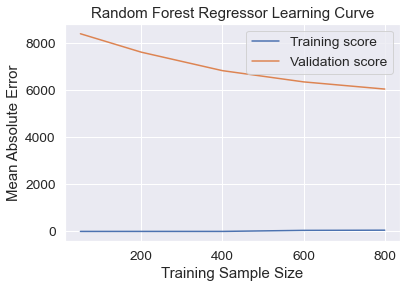

In [277]:
train_scores_mean = np.mean(train_scores, axis=1)
valid_scores_mean = np.mean(valid_scores, axis=1)
plt.plot(train_sizes, train_scores_mean, label="Training score")
plt.plot(train_sizes, valid_scores_mean, label="Validation score")
plt.legend()
plt.title('Random Forest Regressor Learning Curve')
plt.xlabel('Training Sample Size')
plt.ylabel('Mean Absolute Error')

In [285]:
#apply pca to data before ridge regression
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

pca = PCA() #87
pca.fit(OH_X_train)

X_train_reduced = pca.transform(OH_X_train)
X_test_reduced = pca.transform(OH_X_test)


scale = StandardScaler()
OH_X_train_scaled = scale.fit_transform(OH_X_train)
OH_X_test_scaled = scale.fit_transform(OH_X_test)

r_model = Ridge(alpha = 208)
r_model.fit(OH_X_train_scaled, y_train)
r_pred = r_model.predict(OH_X_test)

ridge_scores = cross_val_score(r_model, OH_X_train_scaled, y_train, cv=5, scoring= mae_scorer)

print(ridge_scores)
r_scores_mean = np.mean(ridge_scores)
print(r_scores_mean)


r_predict = r_model.predict(OH_X_test_scaled)
mean_absolute_error(y_test, r_predict)

[-8486.89109014 -7150.90291831 -7930.4014941  -7307.0322318
 -7676.35604832]
-7710.316756537235


8913.545627708862

In [286]:
from sklearn.model_selection import RandomizedSearchCV
r_opt = RandomizedSearchCV(
    estimator = Ridge(),
    param_distributions = {'alpha': range(1, 300),
    },
    n_iter=60,
    cv=5,
    scoring= mae_scorer
)

r_opt.fit(OH_X_train, y_train)

print("val. score: %s" % r_opt.best_score_)
#print("test score: %s" % r_opt.score(OH_X_test, y_test))

val. score: -8172.6428290096155


In [224]:
print("best params: %s" % str(r_opt.best_estimator_))
r_opt

best params: Ridge(alpha=208)


RandomizedSearchCV(cv=5, estimator=Ridge(), n_iter=100,
                   param_distributions={'alpha': range(50, 300)},
                   scoring=make_scorer(mean_absolute_error, greater_is_better=False))

Text(0, 0.5, 'Mean Absolute Error ($)')

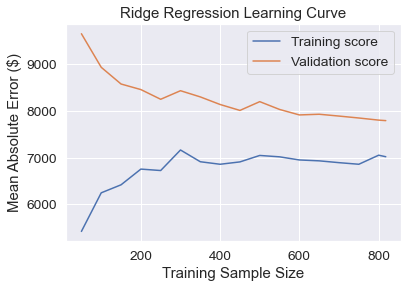

In [278]:
from sklearn.model_selection import learning_curve

train_list = [50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 818]
train_sizes, train_scores, valid_scores = learning_curve(r_model, OH_X_train_scaled, y_train, train_sizes = train_list, cv=5, scoring = pos_mae_scorer)

train_scores_mean = np.mean(train_scores, axis=1)
valid_scores_mean = np.mean(valid_scores, axis=1)
plt.plot(train_sizes, train_scores_mean, label="Training score")
plt.plot(train_sizes, valid_scores_mean, label="Validation score")
plt.legend()
plt.title('Ridge Regression Learning Curve')
plt.xlabel('Training Sample Size')
plt.ylabel('Mean Absolute Error ($)')

[-8829.29813694 -7359.27004437 -8002.61002304 -7325.11186516
 -7644.78331224]
-7832.2146763508235


Text(0, 0.5, 'Mean Absolute Error ($)')

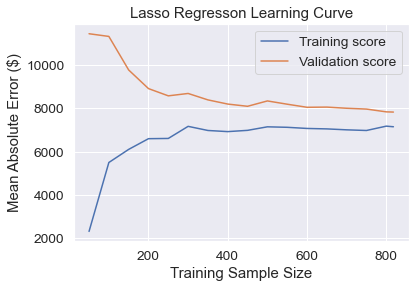

In [279]:
# Test a Lasso regressor 
from sklearn.linear_model import Lasso

# Create Lasso model
lasso_model = Lasso(alpha = 7,normalize=True, max_iter=1e9)
lasso_model.fit(OH_X_train, y_train)
lasso_pred = lasso_model.predict(OH_X_test)

# Score lasso model using cross validation
lasso_scores = cross_val_score(lasso_model, OH_X_train, y_train, cv=5, scoring= mae_scorer)
print(lasso_scores)
lasso_mean = np.mean(lasso_scores)
print(lasso_mean)

# Plot learning curve
train_list = [50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 818]
train_sizes, train_scores, valid_scores = learning_curve(lasso_model, OH_X_train_scaled, y_train, train_sizes = train_list, cv=5, scoring = pos_mae_scorer)

train_scores_mean = np.mean(train_scores, axis=1)
valid_scores_mean = np.mean(valid_scores, axis=1)
plt.plot(train_sizes, train_scores_mean, label="Training score")
plt.plot(train_sizes, valid_scores_mean, label="Validation score")
plt.legend();
plt.title('Lasso Regresson Learning Curve')
plt.xlabel('Training Sample Size')
plt.ylabel('Mean Absolute Error ($)')

In [229]:
# Baysian optimization for lasso model
lasso_opt = BayesSearchCV(
    Lasso(max_iter=1e9),
    {
        'alpha': (0.001, 100), 
    },
    n_iter=35,
    cv=3,
    scoring= mae_scorer

)

lasso_opt.fit(OH_X_train, y_train)

print("val. score: %s" % lasso_opt.best_score_)
print("test score: %s" % lasso_opt.score(OH_X_test, y_test))

val. score: -8181.89694112239
test score: -9755.30242542433


In [231]:
# Pull best parameters
print("best params: %s" % str(lasso_opt.best_params_))

best params: OrderedDict([('alpha', 23.0855143294036)])


In [281]:
# Create XGboost regressor 
from xgboost import XGBRegressor

#split up data. 
train_ratio = 0.90
#validation_ratio = 0.15
test_ratio = 0.10

x_xg_train, x_valid, y_xg_train, y_valid = train_test_split(OH_X_train, y_train, test_size=1 - train_ratio, random_state = 0)

xgbr_model = XGBRegressor(n_estimators=1500, learning_rate=0.05, max_depth = 6)
xgbr_model.fit(OH_X_train, y_train)

xgbr_scores = cross_val_score(xgbr_model, OH_X_train, y_train, cv=5, scoring = mae_scorer)
print(xgbr_scores)
xgbr_mean = np.mean(xgbr_scores)
print(xgbr_mean)

xgbr_predict = xgbr_model.predict(OH_X_test)
mean_absolute_error(y_test, xgbr_predict)

[-6038.87596827 -6585.41537371 -5803.28496362 -5722.10745284
 -6057.96075588]
-6041.528902863944


6911.090998641304

In [251]:
xgbr_opt = RandomizedSearchCV(
    XGBRegressor(n_estimators=1500, learning_rate=0.05),
    {
    'max_depth': range(2, 10),
    },
    n_iter=40,
    cv=5,
    scoring= mae_scorer

)

xgbr_opt.fit(OH_X_train, y_train)

print("val. score: %s" % test.best_score_)

val. score: 6188.646241270368


In [252]:
print("best params: %s" % str(xgbr_opt.best_params_))

best params: {'max_depth': 3}


Text(0, 0.5, 'Mean Absolute Error ($)')

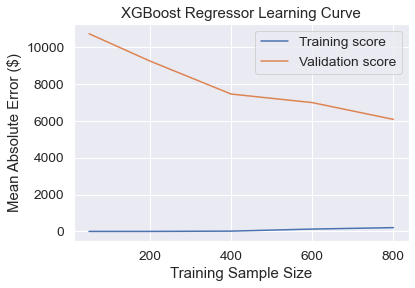

In [282]:
train_list = [50, 200, 400, 600, 800]
train_sizes, train_scores, valid_scores = learning_curve(xgbr_model, OH_X_train, y_train, train_sizes = train_list, cv=5, scoring = pos_mae_scorer)

train_scores_mean = np.mean(train_scores, axis=1)
valid_scores_mean = np.mean(valid_scores, axis=1)
plt.plot(train_sizes, train_scores_mean, label="Training score")
plt.plot(train_sizes, valid_scores_mean, label="Validation score")
plt.legend();
plt.title('XGBoost Regressor Learning Curve')
plt.xlabel('Training Sample Size')
plt.ylabel('Mean Absolute Error ($)')

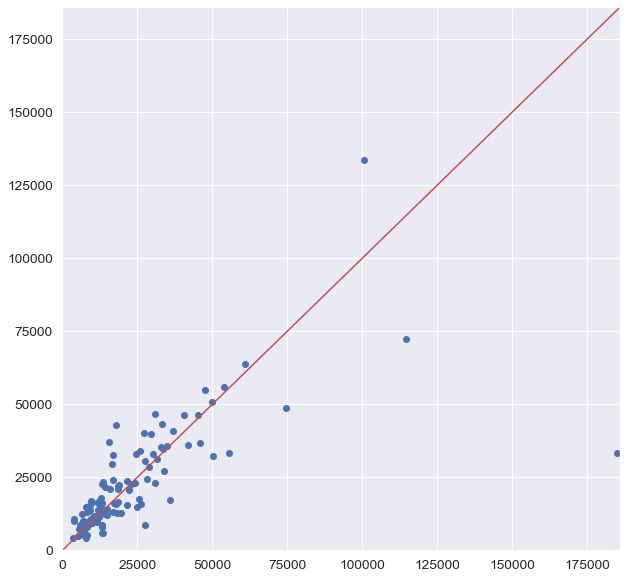

In [55]:
plt.figure(figsize=(10, 10))
fig = plt.scatter(y_test, xgbr_predict)
plt.xlim(0, 186000)
plt.ylim(0, 186000)
x = np.linspace(0,186000 ,186000)
y = x
plt.plot(x, y, '-r', label='y= x')

In [56]:
import eli5
from eli5.sklearn import PermutationImportance

#split up data. 
train_ratio = 0.90
#validation_ratio = 0.15
test_ratio = 0.10

perm_x_train, x_valid, perm_y_train, y_valid = train_test_split(OH_X_train, y_train, test_size=1 - train_ratio, random_state = 0)

perm = PermutationImportance(xgbr_model, random_state=0).fit(x_valid, y_valid)
eli5.show_weights(perm, feature_names = x_valid.columns.tolist())

C:\Users\Justyn\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\Users\Justyn\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


Weight,Feature
0.9103 ± 0.2570,Horsepower
0.5652 ± 0.0874,Year
0.3128 ± 0.1052,Mileage
0.1387 ± 0.5424,BodyStyle_Truck
0.0848 ± 0.0296,Torque
0.0675 ± 0.0064,BodyStyle_Van/Minivan
0.0379 ± 0.0098,Make_Ferrari
0.0367 ± 0.0192,Transmission_manual (6-speed)
0.0324 ± 0.0377,Reserve_Has reserve
0.0295 ± 0.0096,Make_Porsche


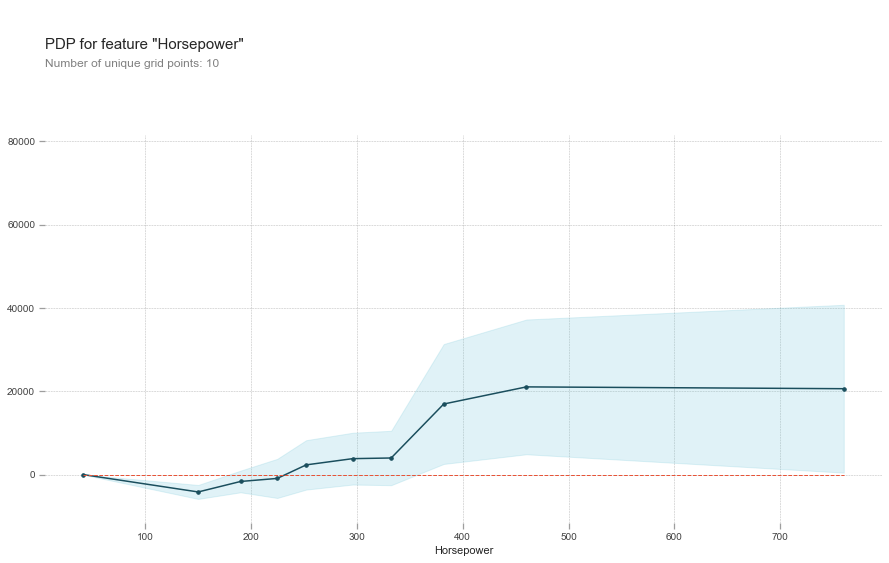

In [66]:
import graphviz
from sklearn import tree

from pdpbox import pdp, get_dataset, info_plots

feature_names = OH_X_test.columns


# Create the data that we will plot
pdp_horsepower = pdp.pdp_isolate(model=xgbr_model, dataset=OH_X_train, model_features=feature_names, feature='Horsepower')

# plot it
pdp.pdp_plot(pdp_horsepower, 'Horsepower')
plt.show()

In [79]:
import shap  # package used to calculate Shap values

row_to_show = 75
data_for_prediction = OH_X_test.iloc[[row_to_show]]  # use 1 row of data here. Could use multiple rows if desired

print(y_test.iloc[[row_to_show]])
xgbr_model.predict(data_for_prediction)

# Create object that can calculate shap values
explainer = shap.TreeExplainer(xgbr_model)

# Calculate Shap values
shap_values = explainer.shap_values(data_for_prediction)
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values, data_for_prediction)

420    17200
Name: Price, dtype: int32


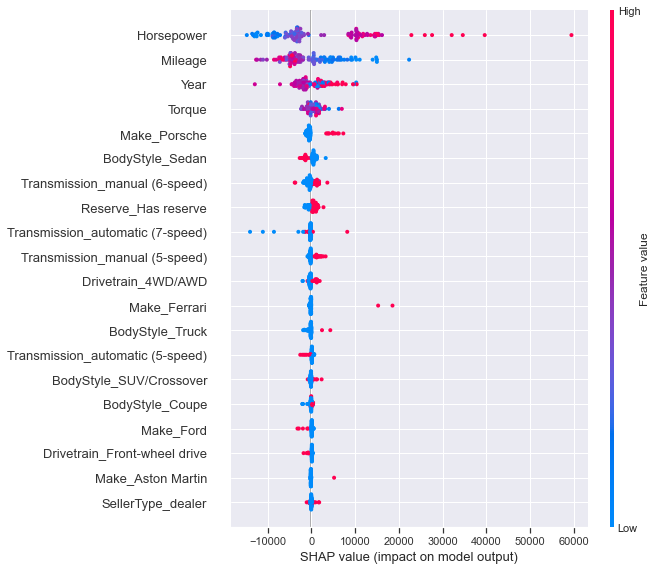

In [59]:
# Create object that can calculate shap values
explainer = shap.TreeExplainer(xgbr_model)

# calculate shap values. This is what we will plot.
# Calculate shap_values for all of val_X rather than a single row, to have more data for plot.
shap_values = explainer.shap_values(OH_X_test)

# Make plot
shap.summary_plot(shap_values, OH_X_test)

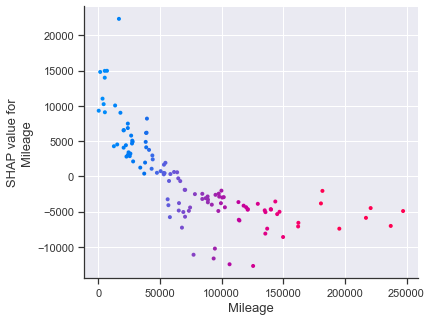

In [60]:
# Create object that can calculate shap values
explainer = shap.TreeExplainer(xgbr_model)

# calculate shap values. This is what we will plot.
shap_values = explainer.shap_values(OH_X_test)

# make plot.
shap.dependence_plot('Mileage', shap_values, OH_X_test, interaction_index="Mileage")

[ 9099.99923064 10028.3387414   9575.52801687  8967.76495655
  8291.80291129]
9192.686771350966


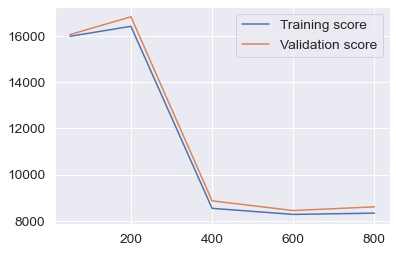

In [61]:
#test out a neural network model
from sklearn.neural_network import MLPRegressor

mlpr_model = MLPRegressor(random_state=0, max_iter=5000).fit(OH_X_train, y_train)
mlpr_model.fit(OH_X_train, y_train)
mlpr_pred = mlpr_model.predict(OH_X_test)

mlpr_scores = cross_val_score(mlpr_model, OH_X_train, y_train, cv=5, scoring= mae_scorer)
print(mlpr_scores)
mlpr_mean = np.mean(mlpr_scores)
print(mlpr_mean)

train_list = [50, 200, 400, 600, 800]
train_sizes, train_scores, valid_scores = learning_curve(mlpr_model, OH_X_train, y_train, train_sizes = train_list, cv=5, scoring = mae_scorer)

train_scores_mean = np.mean(train_scores, axis=1)
valid_scores_mean = np.mean(valid_scores, axis=1)
plt.plot(train_sizes, train_scores_mean, label="Training score")
plt.plot(train_sizes, valid_scores_mean, label="Validation score")
plt.legend();

In [258]:
#encode entire data set 
all_x, OH_encode = OHE(dataX)

# Train model on entire data set
final_model = XGBRegressor(n_estimators=1500, learning_rate=0.05, max_depth = 6)
final_model.fit(all_x, dataY)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.05, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1500, n_jobs=4, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [271]:
# Test final model on new data
# Dictionary of car features
car = {'Year': [2002], 'Make': ['BMW'],'Mileage': [100000],'BodyStyle': ['Sedan'],'Drivetrain': ['4WD/AWD'],'SellerType': ['private party'], 'Reserve': ['Has Reserve'], 'Horsepower': [700], 'Torque': [600], 'Transmission': ['manuel (5-speed)']}

# Convert dictionary to dataframe
car_df = pd.DataFrame(data=car)

# Use function above, input data you want encoded and encoder
car_OH = OHE_trained(car_df, OH_encode)

# Predict car price
final_model.predict(car_OH)

array([15866.996], dtype=float32)

In [ ]:
# Serialize final model using pickle 
import pickle 

# save the model to disk
filename = 'finalized_model.sav'
pickle.dump(final_model, open(filename, 'wb'))

# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(all_x, dataY)

In [ ]:
# Save encoder to disk
encodername = 'OH_encoder.pkl'
pickle.dump(OH_encode, open(encodername, 'wb'))

# Load encoder
load_encoder = pickle.load(open(encodername, 'rb'))